# pykpp Tutorial

    Goals: Predict ozone at a monitor using HYSPLIT and pykpp
    Authors: Barron Henderson, Robert Nedbor-Gross, Qian Shu

<a href="https://colab.research.google.com/github/barronh/pykpp/blob/master/src/pykpp/examples/knote_ae_2015/SummerClean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Overview

1. Create an idealized environment (Knote et al., 2015)
2. Create a simple trajectory model
  - Chemistry - CB05
  - Emissions from NEI
  - Deposition from Knote et al., 2015
  - Dilution following Knote et al., 2015

# Requires Installed Modules

- pykpp: pip install http://github.com/barronh/pykpp/archive/master.zip
  - requires:
    - numpy (Anaconda default installed)
    - scipy (Anaconda default installed)
    - pyparsing (Anaconda default installed)
- matplotlib for plotting  (Anaconda default installed)
- Install before running.
  

In [0]:
!pip install https://github.com/barronh/pykpp/archive/master.zip


# Figure Treatment

- Figures made in the notebook should be treated as inline
- This is done using the `%pylab inline` option

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Knote et al. 2015

This example application is based on the Knote et al. (2015) simulation of a typical summer day with CB05. The example here uses the "Summer" PBL and temperature profile. At present, the example uses the a relatively "clean" initial environment (NOx(t=0) = 1ppb).

# Summer Idealization

  - Values taken from Knote et al. (2015)
  - Saved in tsv: tab separated values

In [2]:
out = open('summerenv.tsv', 'w')
out.write("""time	PBLH	TEMP
0.00	250.	288.15
3600	250.	288.15
7200	250.	288.15
10800	250.	288.15
14400	250.	288.15
18000	300.	288.16
21600	550.	289
25200	850.	292.75
28800	1120	295.93
32400	1300	298.52
36000	1400	300.55
39600	1475	302
43200	1500	302.86
46800	1500	303.15
50400	1500	302.86
54000	1500	302
57600	1500	300.55
61200	1500	298.53
64800	1500	295.93
68400	1500	292.75
72000	1500	289
75600	250.	288.15
79200	250.	288.15
82800	250.	288.15
86400	250.	288.15""")
out.close()

# Trajectory model

We'll use a KPP language to implement the model. Each piece will be saved as a string and then combined to produce an active model.

- prepare an air pracel and model environment
- select gas-phase chemical reactions
- add emissions as chemical reactions
- add deposition as chemical reactions


# Define a function to dilute with PBL
  - In a trajectory model, we need a PBL dilution
  - It should only dilute when PBL goes up
  - When PBL collapses, it should not concentrate
  - This will be called by the mechanism in between integrations

In [3]:
def UpdatePBL(mech, world):
    """
    Defining updater for PBL rise
    """
    if 'y' not in world: return
    PBLH_OLD = world['PBLH_OLD']
    ybkg = world['ybkg']
    y = world['y']
    PBLH = mech.world['PBLH']
    if PBLH != PBLH_OLD:
        KDIL = np.minimum(1, PBLH_OLD / PBLH)
        mech.world['KDIL'] = KDIL
        world['PBLH_OLD'] = PBLH
        ydil = (KDIL * y) + (1 - KDIL) * ybkg
        nonzero = ybkg != 2.4195878568940516e-22
        y[nonzero] = ydil[nonzero]
    else:
        mech.world['KDIL'] = 1
    mech.update_world_from_y(y)

# Prep the parcel

  - basic physical environment
  - a PBL
  - deposition rates
  - a useful constant
  - adding functions to evolve the environment
    - Update_M makes M, O2, N2, and H2
    - Update_THETA calculates the solar zenith angle
    - includes Update_PBL
    - interpolated emissions
    - interpolated physical parameters

In [4]:
prepstr = """#INLINE PY_INIT
TEMP = 298.15
P = 99600.
t = TSTART = 0 * 3600.
TEND = TSTART + 3600. * 24
DT = 60.
MONITOR_DT = 3600
StartDate = 'datetime(2010, 7, 14)'
Latitude_Degrees = 40.
Longitude_Degrees = 0.00E+00
KDIL = 0.
PBLH_OLD = 250.
vd_CO = 0.03
vd_SO2 = 1.8
vd_NO = 0.016
vd_NO2 = 0.1
vd_NO3 = 0.1
vd_N2O5 = 4
vd_HONO = 2.2
vd_HNO3 = 4
vd_HNO4 = 4
vd_O3 = 0.4
vd_H2O2 = 0.5
vd_CH3OOH = 0.1
molps_to_molpcm2ps = Avogadro / 1200000**2
add_world_updater(func_updater(Update_M, incr = 360., verbose = False))
add_world_updater(func_updater(Update_THETA, incr = 360., verbose = False))
add_world_updater(interpolated_from_csv('summerenv.tsv',
                                        'time', incr = 360.,
                                        delimiter = '\\t',
                                        verbose = False))
add_world_updater(interpolated_from_csv('mean_emis.csv',
                                        'time', incr = 360, verbose = False))
add_world_updater(func_updater(Monitor, incr = 7200.,
                               allowforce = False, verbose = False))
#ENDINLINE
"""

# Add the gas-phase equations

  - here we use CB05
  - syntax is KPP
  - special functions
    - CMAQ_1to4: (A * (TEMP/300.0)**B * exp(-C/TEMP))
    - CMAQ_10: Troe fall-off equation
    - CMAQ_8: 
      - 3 CMAQ_1to4 with only A and C parameters
      - K0 + K3*M / (1.0 + K3*M / K2 )
    - TUV_J:
      - photolysis using interpolated TUV
      - clear sky
      - accepts optional scale argument 

In [5]:
# normally borrows from installed package, copying here for clarity
gaschemeqn = """
#EQUATIONS
<R1> NO2 = NO + O : TUV_J(6, THETA);
<R2> O {+ O2 + M} = O3 {+ M} : O2 * M * CMAQ_1to4(6.0E-34, -2.4, 0.0E+00);
<R3> O3 + NO = NO2 : CMAQ_1to4(3.0E-12, 0.0E+00, 1500.0);
<R4> O + NO2 = NO : CMAQ_1to4(5.6E-12, 0.0E+00, -180.0);
<R5> O + NO2 = NO3 : CMAQ_10(2.5E-31, -1.8, 0.0E+00, 2.2E-11, -0.7, 0.0E+00, 0.6, 1.0);
<R6> O + NO = NO2 : CMAQ_10(9.0E-32, -1.5, 0.0E+00, 3.0E-11, 0.0E+00, 0.0E+00, 0.6, 1.0);
<R7> NO2 + O3 = NO3 : CMAQ_1to4(1.2E-13, 0.0E+00, 2450.0);
<R8> O3 = O : TUV_J(3, THETA); 
<R9> O3 = O1D : TUV_J(2, THETA);
<R10> O1D {+ M} = O {+ M} : M * CMAQ_1to4(2.1E-11, 0.0E+00, -102.);
<R11> O1D {+ H2O} = 2.000 OH : H2O * CMAQ_1to4(2.2E-10, 0.0E+00, 0.0E+00);
<R12> O3 + OH = HO2 : CMAQ_1to4(1.7E-12, 0.0E+00, 940.0);
<R13> O3 + HO2 = OH : CMAQ_1to4(1.0E-14, 0.0E+00, 490.0);
<R14> NO3 = NO2 + O : TUV_J(8, THETA);
<R15> NO3 = NO : TUV_J(7, THETA);
<R16> NO3 + NO = 2.000 NO2 : CMAQ_1to4(1.5E-11, 0.0E+00, -170.0);
<R17> NO3 + NO2 = NO + NO2 : CMAQ_1to4(4.5E-14, 0.0E+00, 1260.0);
<R18> NO3 + NO2 = N2O5 : CMAQ_10(2.0E-30, -4.4, 0.0E+00, 1.4E-12, -0.7, 0.0E+00, 0.6, 1.0);
<R19> N2O5 {+ H2O} = 2.000 HNO3 + DUMMY : H2O * CMAQ_1to4(2.5E-22, 0.0E+00, 0.0E+00);
<R20> N2O5 {+ H2O + H2O} = 2.000 HNO3 : H2O**2 * CMAQ_1to4(1.8E-39, 0.0E+00, 0.0E+00);
<R21> N2O5 = NO3 + NO2 + DUMMY : CMAQ_10(1.0E-03, -3.5, 11000.0, 9.7E+14, 0.1, 11080.0, 0.45, 1.0);
<R22> NO + NO {+ O2} = 2.000 NO2 : O2 * CMAQ_1to4(3.3E-39, 0.0E+00, -530.0);
<R23> NO + NO2 {+ H2O} = 2.000 HONO : H2O * CMAQ_1to4(5.0E-40, 0.0E+00, 0.0E+00);
<R24> NO + OH = HONO : CMAQ_10(7.0E-31, -2.6, 0.0E+00, 3.6E-11, -0.1, 0.0E+00, 0.6, 1.0);
<R25> HONO = NO + OH : TUV_J(12, THETA);
<R26> OH + HONO = NO2 : CMAQ_1to4(1.8E-11, 0.0E+00, 390.0);
<R27> HONO + HONO = NO + NO2 : CMAQ_1to4(1.0E-20, 0.0E+00, 0.0E+00);
<R28> NO2 + OH = HNO3 : CMAQ_10(2.0E-30, -3.0, 0.0E+00, 2.5E-11, 0.0E+00, 0.0E+00, 0.6, 1.0);
<R29> OH + HNO3 = NO3 : CMAQ_8(2.4E-14, -460.0, 2.7E-17, -2199.0, 6.5E-34, -1335.0);
<R30> HO2 + NO = OH + NO2 : CMAQ_1to4(3.5E-12, 0.0E+00, -250.0);
<R31> HO2 + NO2 = PNA : CMAQ_10(1.8E-31, -3.2, 0.0E+00, 4.7E-12, 0.0E+00, 0.0E+00, 0.6, 1.0);
<R32> PNA = HO2 + NO2 : CMAQ_10(4.1E-5, 0.0E+00, 10650.0, 4.8E15, 0.0E+00, 11170.0, 0.6, 1.0);
<R33> OH + PNA = NO2 : CMAQ_1to4(1.3E-12, 0.0E+00, -380.0);
<R34> HO2 + HO2 = H2O2 + DUMMY : CMAQ_9(2.3E-13, -6.0E+02, 1.7E-33, -1.0E+03);
<R35> HO2 + HO2 {+ H2O} = H2O2 : H2O * CMAQ_9(3.22E-34, -2.8E+03, 2.38E-54, -3.2E+3);
<R36> H2O2 = 2.000 OH : TUV_J(5, THETA);
<R37> OH + H2O2 = HO2 : CMAQ_1to4(2.9E-12, 0.0E+00, 160.0);
<R38> O1D {+ H2} = OH + HO2 : H2 * CMAQ_1to4(1.1E-10, 0.0E+00, 0.0E+00);
<R39> OH {+ H2} = HO2 : H2 * CMAQ_1to4(5.5E-12, 0.0E+00, 2000.) {IUPAC '06 at 230K evaluates 9/10 * this};
<R40> OH + O = HO2 : CMAQ_1to4(2.2E-11, 0.0E+00, -120.);
<R41> OH + OH = O : CMAQ_1to4(4.2E-12, 0.0E+00, 240.0) {IUPAC '06 at 230K evaluates 4/3* this};
<R42> OH + OH = H2O2 : CMAQ_10(6.9E-31, -1.0, 0.0E+00, 2.6E-11, 0.0E+00, 0.0E+00, 0.6, 1.0);
<R43> OH + HO2 = DUMMY : CMAQ_1to4(4.8E-11, 0.0E+00, -250.);
<R44> HO2 + O = OH : CMAQ_1to4(3.0E-11, 0.0E+00, -200.);
<R45> H2O2 + O = OH + HO2 : CMAQ_1to4(1.4E-12, 0.0E+00, 2000.);
<R46> NO3 + O = NO2 : CMAQ_1to4(1.0E-11, 0.0E+00, 0.0E+00);
<R47> NO3 + OH = HO2 + NO2 : CMAQ_1to4(2.2E-11, 0.0E+00, 0.0E+00);
<R48> NO3 + HO2 = HNO3 : CMAQ_1to4(3.5E-12, 0.0E+00, 0.0E+00);
<R49> NO3 + O3 = NO2 : CMAQ_1to4(1.0E-17, 0.0E+00, 0.0E+00);
<R50> NO3 + NO3 = 2.000 NO2 : CMAQ_1to4(8.5E-13, 0.0E+00, 2450.);
<R51> PNA = 0.610 HO2 + 0.610 NO2 + 0.390 OH + 0.390 NO3 : JHNO4_NEAR_IR(TUV_J(14, THETA)); 
<R52> HNO3 = OH + NO2 : TUV_J(13, THETA);
<R53> N2O5 = NO2 + NO3 : TUV_J(10, THETA); {what about N2O5 -> NO3 + NO + O3P; BHH TUV_J(9, THETA)+}
<R54> XO2 + NO = NO2 : CMAQ_1to4(2.6E-12, 0.0E+00, -365.0);
<R55> XO2N + NO = NTR : CMAQ_1to4(2.6E-12, 0.0E+00, -365.0);
<R56> XO2 + HO2 = ROOH : CMAQ_1to4(7.5E-13, 0.0E+00, -700.0);
<R57> XO2N + HO2 = ROOH : CMAQ_1to4(7.5E-13, 0.0E+00, -700.0);
<R58> XO2 + XO2 = DUMMY : CMAQ_1to4(6.8E-14, 0.0E+00, 0.0E+00);
<R59> XO2N + XO2N = DUMMY : CMAQ_1to4(6.8E-14, 0.0E+00, 0.0E+00);
<R60> XO2 + XO2N = DUMMY : CMAQ_1to4(6.8E-14, 0.0E+00, 0.0E+00);
<R61> NTR + OH = HNO3 + HO2 + 0.330 FORM + 0.330 ALD2 + 0.330 ALDX - 0.660 PAR : CMAQ_1to4(5.9E-13, 0.0E+00, 360.);
<R62> NTR = NO2 + HO2 + 0.330 FORM + 0.330 ALD2 + 0.330 ALDX - 0.660 PAR : TUV_J(36, THETA); {changed to 36}
<R63> ROOH + OH = XO2 + 0.500 ALD2 + 0.500 ALDX : CMAQ_1to4(3.01E-12, 0.0E+00, -190.0);
<R64> ROOH = OH + HO2 + 0.500 ALD2 + 0.500 ALDX : TUV_J(31, THETA); {changed to 31, temporary}
<R65> OH + CO = HO2 : CMAQ_9(1.44E-13, 0.0E+00, 3.43E-33, 0.0E+00);
<R66> OH + CH4 = MEO2 : CMAQ_1to4(2.45E-12, 0.0E+00, 1775.0);
<R67> MEO2 + NO = FORM + HO2 + NO2 : CMAQ_1to4(2.8E-12, 0.0E+00, -300.0);
<R68> MEO2 + HO2 = MEPX : CMAQ_1to4(4.1E-13, 0.0E+00, -750.0);
<R69> MEO2 + MEO2 = 1.370 FORM + 0.740 HO2 + 0.630 MEOH : CMAQ_1to4(9.5E-14, 0.0E+00, -390.0);
<R70> MEPX + OH = 0.700 MEO2 + 0.300 XO2 + 0.300 HO2 : CMAQ_1to4(3.8E-12, 0.0E+00, -200.0);
<R71> MEPX = FORM + HO2 + OH : TUV_J(31, THETA);{changed to 31} 
<R72> MEOH + OH = FORM + HO2 : CMAQ_1to4(7.3E-12, 0.0E+00, 620.0);
<R73> FORM + OH = HO2 + CO : CMAQ_1to4(9.0E-12, 0.0E+00, 0.0E+00);
<R74> FORM = 2.000 HO2 + CO : TUV_J(17, THETA);
<R75> FORM = CO : TUV_J(18, THETA);
<R76> FORM + O = OH + HO2 + CO : CMAQ_1to4(3.4E-11, 0.0E+00, 1600.0);
<R77> FORM + NO3 = HNO3 + HO2 + CO : CMAQ_1to4(5.8E-16, 0.0E+00, 0.0E+00);
<R78> FORM + HO2 = HCO3 : CMAQ_1to4(9.7E-15, 0.0E+00, -625.0);
<R79> HCO3 = FORM + HO2 : CMAQ_1to4(2.4E+12, 0.0E+00, 7000.0);
<R80> HCO3 + NO = FACD + NO2 + HO2 : CMAQ_1to4(5.6E-12, 0.0E+00, 0.0E+00);
<R81> HCO3 + HO2 = MEPX : CMAQ_1to4(5.6E-15, 0.0E+00, -2300.0);
<R82> FACD + OH = HO2 : CMAQ_1to4(4.0E-13, 0.0E+00, 0.0E+00);
<R83> ALD2 + O = C2O3 + OH : CMAQ_1to4(1.8E-11, 0.0E+00, 1100.0);
<R84> ALD2 + OH = C2O3 : CMAQ_1to4(5.6E-12, 0.0E+00, -270.0);
<R85> ALD2 + NO3 = C2O3 + HNO3 : CMAQ_1to4(1.4E-12, 0.0E+00, 1900.0);
<R86> ALD2 = MEO2 + CO + HO2 : TUV_J(19, THETA)+TUV_J(21, THETA);
<R87> C2O3 + NO = MEO2 + NO2 : CMAQ_1to4(8.1E-12, 0.0E+00, -270.0);
<R88> C2O3 + NO2 = PAN : CMAQ_10(2.7E-28, -7.1, 0.0E+00, 1.2E-11, -0.9, 0.0E+00, 0.3, 1.0);
<R89> PAN = C2O3 + NO2 + DUMMY : CMAQ_10(4.9E-3, 0.0E+00, 12100.0, 5.4E16, 0.0E+00, 13830.0, 0.3, 1.0);
<R90> PAN = C2O3 + NO2 : TUV_J(40, THETA)+TUV_J(41, THETA);
<R91> C2O3 + HO2 = 0.800 PACD + 0.200 AACD + 0.200 O3 : CMAQ_1to4(4.3E-13, 0.0E+00, -1040.0);
<R92> C2O3 + MEO2 = 0.900 MEO2 + 0.900 HO2 + FORM + 0.100 AACD : CMAQ_1to4(2.0E-12, 0.0E+00, -500.0);
<R93> C2O3 + XO2 = 0.900 MEO2 + 0.100 AACD : CMAQ_1to4(4.4E-13, 0.0E+00, -1070.0);
<R94> C2O3 + C2O3 = 2.000 MEO2 : CMAQ_1to4(2.9E-12, 0.0E+00, -500.0) {same as IUPAC};
<R95> PACD + OH = C2O3 : CMAQ_1to4(4.0E-13, 0.0E+00, -200.0);
<R96> PACD = MEO2 + OH : TUV_J(33, THETA); {CB05 uses CH3C(O)OOH based on email from G. Yarwood at Environ, but this is superceded by TUV. Changed to33}
<R97> AACD + OH = MEO2 : CMAQ_1to4(4.0E-13, 0.0E+00, -200.0);
<R98> ALDX + O = CXO3 + OH : CMAQ_1to4(1.3E-11, 0.0E+00, 870.0);
<R99> ALDX + OH = CXO3 : CMAQ_1to4(5.1E-12, 0.0E+00, -405.0);
<R100> ALDX + NO3 = CXO3 + HNO3 : CMAQ_1to4(6.5E-15, 0.0E+00, 0.0E+00);
<R101> ALDX = MEO2 + CO + HO2 : TUV_J(22, THETA);
<R102> CXO3 + NO = ALD2 + NO2 + HO2 + XO2 : CMAQ_1to4(6.7E-12, 0.0E+00, -340.0);
<R103> CXO3 + NO2 = PANX : CMAQ_10(2.7E-28, -7.1, 0.0E+00, 1.2E-11, -0.9, 0.0E+00, 0.3, 1.0);
<R104> PANX = CXO3 + NO2 + DUMMY : CMAQ_10(4.9E-3, 0.0E+00, 12100.0, 5.4E16, 0.0E+00, 13830.0, 0.3, 1.0);
<R105> PANX = CXO3 + NO2 : TUV_J(42, THETA)+TUV_J(43, THETA); {changed to 42 and 43}
<R106> PANX + OH = ALD2 + NO2 : CMAQ_1to4(3.0E-13, 0.0E+00, 0.0E+00);
<R107> CXO3 + HO2 = 0.800 PACD + 0.200 AACD + 0.200 O3 : CMAQ_1to4(4.3E-13, 0.0E+00, -1040.0);
<R108> CXO3 + MEO2 = 0.900 ALD2 + 0.900 XO2 + HO2 + 0.100 AACD + 0.100 FORM : CMAQ_1to4(2.0E-12, 0.0E+00, -500.0);
<R109> CXO3 + XO2 = 0.900 ALD2 + 0.100 AACD : CMAQ_1to4(4.4E-13, 0.0E+00, -1070.);
<R110> CXO3 + CXO3 = 2.000 ALD2 + 2.000 XO2 + 2.000 HO2 : CMAQ_1to4(2.9E-12, 0.0E+00, -500.0);
<R111> CXO3 + C2O3 = MEO2 + XO2 + HO2 + ALD2 : CMAQ_1to4(2.9E-12, 0.0E+00, -500.0);
<R112> PAR + OH = 0.870 XO2 + 0.130 XO2N + 0.110 HO2 + 0.060 ALD2 - 0.110 PAR + 0.760 ROR + 0.050 ALDX : CMAQ_1to4(8.1E-13, 0.0E+00, 0.0E+00);
<R113> ROR = 0.960 XO2 + 0.600 ALD2 + 0.940 HO2 - 2.100 PAR + 0.040 XO2N + 0.020 ROR + 0.500 ALDX : CMAQ_1to4(1.E+15, 0.0E+00, 8000.);
<R114> ROR = HO2 : CMAQ_1to4(1.6E+3, 0.0E+00, 0.0E+00);
<R115> ROR + NO2 = NTR : CMAQ_1to4(1.5E-11, 0.0E+00, 0.0E+00);
<R116> O + OLE = 0.200 ALD2 + 0.300 ALDX + 0.300 HO2 + 0.200 XO2 + 0.200 CO + 0.200 FORM + 0.010 XO2N + 0.200 PAR + 0.100 OH : CMAQ_1to4(1.E-11, 0.0E+00, 280.);
<R117> OH + OLE = 0.800 FORM + 0.330 ALD2 + 0.620 ALDX + 0.800 XO2 + 0.950 HO2 - 0.700 PAR : CMAQ_1to4(3.2E-11, 0.0E+00, 0.0E+00);
<R118> O3 + OLE = 0.180 ALD2 + 0.740 FORM + 0.320 ALDX + 0.220 XO2 + 0.100 OH + 0.330 CO + 0.440 HO2 - 1.000 PAR : CMAQ_1to4(6.5E-15, 0.0E+00, 1900.);
<R119> NO3 + OLE = NO2 + FORM + 0.910 XO2 + 0.090 XO2N + 0.560 ALDX + 0.350 ALD2 - 1.000 PAR : CMAQ_1to4(7.0E-13, 0.0E+00, 2160.);
<R120> O + ETH = FORM + 1.700 HO2 + CO + 0.700 XO2 + 0.300 OH : CMAQ_1to4(1.04E-11, 0.0E+00, 792.0);
<R121> OH + ETH = XO2 + 1.560 FORM + 0.220 ALDX + HO2 : CMAQ_10(1.0E-28, -0.8, 0.0E+00, 8.8E-12, 0.0E+00, 0.0E+00, 0.6, 1.0);
<R122> O3 + ETH = FORM + 0.630 CO + 0.130 HO2 + 0.130 OH + 0.370 FACD : CMAQ_1to4(1.2E-14, 0.0E+00, 2630.0);
<R123> NO3 + ETH = NO2 + XO2 + 2.0 FORM : CMAQ_1to4(3.3E-12, 0.0E+00, 2880.);
<R124> IOLE + O = 1.240 ALD2 + 0.660 ALDX + 0.100 HO2 + 0.100 XO2 + 0.100 CO + 0.100 PAR : CMAQ_1to4(2.3E-11, 0.0E+00, 0.0E+00);
<R125> IOLE + OH = 1.300 ALD2 + 0.700 ALDX + HO2 + XO2 : CMAQ_1to4(1.0E-11, 0.0E+00, -550.);
<R126> IOLE + O3 = 0.650 ALD2 + 0.350 ALDX + 0.250 FORM + 0.250 CO + 0.500 O + 0.500 OH + 0.500 HO2 : CMAQ_1to4(8.4E-15, 0.0E+00, 1100.);
<R127> IOLE + NO3 = 1.180 ALD2 + 0.640 ALDX + HO2 + NO2 : CMAQ_1to4(9.6E-13, 0.0E+00, 270.);
<R128> TOL + OH = 0.440 HO2 + 0.080 XO2 + 0.360 CRES + 0.560 TO2 + 0.765 TOLRO2 : CMAQ_1to4(1.8E-12, 0.0E+00, -355.0);
<R129> TO2 + NO = 0.900 NO2 + 0.900 HO2 + 0.900 OPEN + 0.100 NTR : CMAQ_1to4(8.1E-12, 0.0E+00, 0.0E+00);
<R130> TO2 = CRES + HO2 : CMAQ_1to4(4.2E+00, 0.0E+00, 0.0E+00);
<R131> OH + CRES = 0.400 CRO + 0.600 XO2 + 0.600 HO2 + 0.300 OPEN : CMAQ_1to4(4.1E-11, 0.0E+00, 0.0E+00);
<R132> CRES + NO3 = CRO + HNO3 : CMAQ_1to4(2.2E-11, 0.0E+00, 0.0E+00);
<R133> CRO + NO2 = NTR : CMAQ_1to4(1.4E-11, 0.0E+00, 0.0E+00);
<R134> CRO + HO2 = CRES : CMAQ_1to4(5.5E-12, 0.0E+00, 0.0E+00);
<R135> OPEN = C2O3 + HO2 + CO : 9.0 * TUV_J(17, THETA);
<R136> OPEN + OH = XO2 + 2.000 CO + 2.000 HO2 + C2O3 + FORM : CMAQ_1to4(3.0E-11, 0.0E+00, 0.0E+00);
<R137> OPEN + O3 = 0.030 ALDX + 0.620 C2O3 + 0.700 FORM + 0.030 XO2 + 0.690 CO + 0.080 OH + 0.760 HO2 + 0.200 MGLY : CMAQ_1to4(5.4E-17, 0.0E+00, 500.);
<R138> OH + XYL = 0.700 HO2 + 0.500 XO2 + 0.200 CRES + 0.800 MGLY + 1.100 PAR + 0.300 TO2 + 0.804 XYLRO2 : CMAQ_1to4(1.7E-11, 0.0E+00, -116.);
<R139> OH + MGLY = XO2 + C2O3 : CMAQ_1to4(1.8E-11, 0.0E+00, 0.0E+00);
<R140> MGLY = C2O3 + HO2 + CO : TUV_J(46, THETA); {changed to 46}
<R141> O + ISOP = 0.750 ISPD + 0.500 FORM + 0.250 XO2 + 0.250 HO2 + 0.250 CXO3 + 0.250 PAR : CMAQ_1to4(3.6E-11, 0.0E+00, 0.0E+00);
<R142> OH + ISOP = 0.912 ISPD + 0.629 FORM + 0.991 XO2 + 0.912 HO2 + 0.088 XO2N + ISOPRXN : CMAQ_1to4(2.54E-11, 0.0E+00, -407.6);
<R143> O3 + ISOP = 0.650 ISPD + 0.600 FORM + 0.200 XO2 + 0.066 HO2 + 0.266 OH + 0.200 CXO3 + 0.150 ALDX + 0.350 PAR + 0.066 CO : CMAQ_1to4(7.86E-15, 0.0E+00, 1912.0);
<R144> NO3 + ISOP = 0.200 ISPD + 0.800 NTR + XO2 + 0.800 HO2 + 0.200 NO2 + 0.800 ALDX + 2.400 PAR : CMAQ_1to4(3.03E-12, 0.0E+00, 448.0);
<R145> OH + ISPD = 1.565 PAR + 0.167 FORM + 0.713 XO2 + 0.503 HO2 + 0.334 CO + 0.168 MGLY + 0.252 ALD2 + 0.210 C2O3 + 0.250 CXO3 + 0.120 ALDX : CMAQ_1to4(3.36E-11, 0.0E+00, 0.0E+00);
<R146> O3 + ISPD = 0.114 C2O3 + 0.150 FORM + 0.850 MGLY + 0.154 HO2 + 0.268 OH + 0.064 XO2 + 0.020 ALD2 + 0.360 PAR + 0.225 CO : CMAQ_1to4(7.1E-18, 0.0E+00, 0.0E+00);
<R147> NO3 + ISPD = 0.357 ALDX + 0.282 FORM + 1.282 PAR + 0.925 HO2 + 0.643 CO + 0.850 NTR + 0.075 CXO3 + 0.075 XO2 + 0.150 HNO3 : CMAQ_1to4(1.0E-15, 0.0E+00, 0.0E+00);
<R148> ISPD = 0.333 CO + 0.067 ALD2 + 0.900 FORM + 0.832 PAR + 1.033 HO2 + 0.700 XO2 + 0.967 C2O3 : 0.0036 * TUV_J(24, THETA) {BHH: Is this right?};
<R149> TERP + O = 0.150 ALDX + 5.12 PAR + TRPRXN : CMAQ_1to4(3.6E-11, 0.0E+00, 0.0E+00);
<R150> TERP + OH = 0.750 HO2 + 1.250 XO2 + 0.250 XO2N + 0.280 FORM + 1.66  PAR + 0.470 ALDX + TRPRXN : CMAQ_1to4(1.5E-11, 0.0E+00, -449.);
<R151> TERP + O3 = 0.570 OH + 0.070 HO2 + 0.760 XO2 + 0.180 XO2N + 0.240 FORM + 0.001 CO + 7.000 PAR + 0.210 ALDX + 0.390 CXO3 + TRPRXN : CMAQ_1to4(1.2E-15, 0.0E+00, 821.);
<R152> TERP + NO3 = 0.470 NO2 + 0.280 HO2 + 1.030 XO2 + 0.250 XO2N + 0.470 ALDX + 0.530 NTR + TRPRXN : CMAQ_1to4(3.7E-12, 0.0E+00, -175.);
<R153> SO2 + OH = SULF + HO2 + SULRXN : CMAQ_10(3.0E-31, -3.3, 0.0E+00, 1.5E-12, 0.0E+00, 0.0E+00, 0.6, 1.0);
<R154> OH + ETOH = HO2 + 0.900 ALD2 + 0.050 ALDX + 0.100 FORM + 0.100 XO2 : CMAQ_1to4(6.9E-12, 0.0E+00, 230.0);
<R155> OH + ETHA = 0.991 ALD2 + 0.991 XO2 + 0.009 XO2N + HO2 : CMAQ_1to4(8.7E-12, 0.0E+00, 1070.0);
<R156> NO2 + ISOP = 0.200 ISPD + 0.800 NTR + XO2 + 0.800 HO2 + 0.200 NO + 0.800 ALDX + 2.400 PAR : CMAQ_1to4(1.5E-19, 0.0E+00, 0.0E+00);
<CL1> CL2 = 2.000 CL : TUV_J(49, THETA); {changed to 49}
<CL2> HOCL = OH + CL : 0; {TUV_J(HOCL_IUPAC04, THETA)}
<CL3> CL + O3 = CLO : CMAQ_1to4(2.3E-11, 0.0E+00, 200.0);
<CL4> CLO + CLO = 0.300 CL2 + 1.400 CL : CMAQ_1to4(1.63E-14, 0.0E+00, 0.0E+00);
<CL5> CLO + NO = CL + NO2 : CMAQ_1to4(6.4E-12, 0.0E+00, -290.0);
<CL6> CLO + HO2 = HOCL : CMAQ_1to4(2.7E-12, 0.0E+00, -220.0);
<CL7> OH + FMCL = CL + CO : CMAQ_1to4(5.0E-13, 0.0E+00, 0.0E+00);
<CL8> FMCL = CL + CO + HO2 : 0; {TUV_J(FMCL_IUPAC04, THETA)}
<CL9> CL + CH4 = HCL + MEO2 : CMAQ_1to4(6.6E-12, 0.0E+00, 1240.0);
<CL10> CL + PAR = HCL + 0.870 XO2 + 0.130 XO2N + 0.110 HO2 + 0.060 ALD2 - 0.110 PAR + 0.760 ROR + 0.050 ALDX : CMAQ_1to4(5.0E-11, 0.0E+00, 0.0E+00);
<CL11> CL + ETHA = HCL + 0.991 ALD2 + 0.991 XO2 + 0.009 XO2N + HO2 : CMAQ_1to4(8.3E-11, 0.0E+00, 100.0);
<CL12> CL + ETH = FMCL + 2.000 XO2 + 1.000 HO2 + 1.000 FORM : CMAQ_1to4(1.07E-10, 0.0E+00, 0.0E+00);
<CL13> CL + OLE = FMCL + 0.330 ALD2 + 0.670 ALDX + 2.000 XO2 + 1.000 HO2 - 1.000 PAR : CMAQ_1to4(2.5E-10, 0.0E+00, 0.0E+00);
<CL14> CL + IOLE = 0.300 HCL + 0.700 FMCL + 0.450 ALD2 + 0.550 ALDX + 0.300 OLE + 0.300 PAR + 1.700 XO2 + 1.000 HO2 : CMAQ_1to4(3.5E-10, 0.0E+00, 0.0E+00);
<CL15> CL + ISOP = 0.15 HCL + 1.000 XO2 + 1.000 HO2 + 0.850 FMCL + 1.000 ISPD : CMAQ_1to4(4.3E-10, 0.0E+00, 0.0E+00);
<CL16> CL + FORM = HCL + 1.000 HO2 + 1.000 CO : CMAQ_1to4(8.2E-11, 0.0E+00, 34.0);
<CL17> CL + ALD2 = HCL + 1.000 C2O3 : CMAQ_1to4(7.9E-11, 0.0E+00, 0.0E+00);
<CL18> CL + ALDX = HCL + 1.000 CXO3 : CMAQ_1to4(1.3E-10, 0.0E+00, 0.0E+00);
<CL19> CL + MEOH = HCL + 1.000 HO2 + 1.000 FORM : CMAQ_1to4(5.5E-11, 0.0E+00, 0.0E+00);
<CL20> CL + ETOH = HCL + 1.000 HO2 + 1.000 ALD2 : CMAQ_1to4(8.2E-11, 0.0E+00, -45.0);
<CL21> HCL + OH = CL : CMAQ_1to4(6.58E-13, 1.16, -58.0);
<SA01> TOLRO2 + NO = NO + TOLNRXN : CMAQ_1to4(2.70e-12, 0.0E+00, -360.0);
<SA02> TOLRO2 + HO2 = HO2 + TOLHRXN : CMAQ_1to4(1.90e-13, 0.0E+00, -1300.0);
<SA03> XYLRO2 + NO = NO + XYLNRXN : CMAQ_1to4(2.70e-12, 0.0E+00, -360.0);
<SA04> XYLRO2 + HO2 = HO2 + XYLHRXN : CMAQ_1to4(1.90e-13, 0.0E+00, -1300.0);
<SA05> BENZENE + OH = OH + 0.764 BENZRO2 : CMAQ_1to4(2.47e-12, 0.0E+00, 206.0);
<SA06> BENZRO2 + NO = NO + BNZNRXN : CMAQ_1to4(2.70e-12, 0.0E+00, -360.0);
<SA07> BENZRO2 + HO2 = HO2 + BNZHRXN : CMAQ_1to4(1.90e-13, 0.0E+00, -1300.0);
<SA08> SESQ + O3 = O3 + SESQRXN : CMAQ_1to4(1.16E-14, 0.0E+00, 0.0E+00);
<SA09> SESQ + OH = OH + SESQRXN : CMAQ_1to4(1.97E-10, 0.0E+00, 0.0E+00);
<SA10> SESQ + NO3 = NO3 + SESQRXN : CMAQ_1to4(1.90E-11, 0.0E+00, 0.0E+00);
"""

# Add emissions

  - Emissions are extracted from the NEI 2005
  - Units are moles/s/gridcell (12km x 12km) grid cells
  - Save to a file for reading

In [6]:
out = open('mean_emis.csv', 'w')
out.write("""time,emis_ALD2,emis_ALDX,emis_CH4,emis_CL2,emis_CO,emis_ETH,emis_ETHA,emis_ETOH,emis_FORM,emis_HONO,emis_IOLE,emis_ISOP,emis_MEOH,emis_NH3,emis_NO,emis_NO2,emis_OLE,emis_PAR,emis_SESQ,emis_SO2,emis_SULF,emis_TERP,emis_TOL,emis_XYL
0,0.009782475,0.003378729,0.020594137,0.000272824,0.37623799,0.023582038,0.007752421,0.023938367,0.019756878,0.000450755,0.021942778,1.45E-05,0.002004891,0.041319199,0.068131328,0.00608949,0.025636181,0.24303871,0.003029566,0.001919644,1.89E-05,0.045247756,0.00192445,0.001446171
3600,0.009269881,0.0032036,0.019553497,0.000272834,0.32818484,0.022291822,0.007261382,0.022668259,0.018739702,0.000411843,0.020815786,1.39E-05,0.001900662,0.037867632,0.063159242,0.005604534,0.02427806,0.22741607,0.002748217,0.001779459,1.74E-05,0.043026295,0.00172492,0.001283684
7200,0.008881351,0.003073562,0.018970681,0.000272834,0.30460587,0.02133316,0.00693836,0.021744553,0.017963199,0.00039342,0.019950897,1.35E-05,0.00185463,0.035278447,0.060696919,0.005375989,0.023270898,0.21735588,0.002538632,0.001714331,1.68E-05,0.041290648,0.001632145,0.001203938
10800,0.008591107,0.002977591,0.018979864,0.000272834,0.30461517,0.020663343,0.006783442,0.021096248,0.017369084,0.000394752,0.019283054,1.34E-05,0.001868521,0.034206063,0.060659263,0.0053617,0.022538668,0.21222222,0.002376886,0.001724916,1.68E-05,0.039900161,0.001632853,0.001209816
14400,0.00840356,0.002918046,0.019908005,0.000272834,0.34498599,0.02033582,0.006851513,0.02078783,0.016961612,0.000430036,0.018799039,1.35E-05,0.001985938,0.035258923,0.064797856,0.005742832,0.022105472,0.21442311,0.00225107,0.001861314,1.82E-05,0.03879549,0.001797843,0.001358705
18000,0.008343155,0.002901453,0.022410128,0.000272834,0.46381518,0.020544937,0.007251957,0.020866441,0.016797915,0.0005429,0.018501209,1.45E-05,0.002223165,0.039177805,0.078018345,0.007044623,0.022069845,0.2274044,0.002151683,0.002175239,2.11E-05,0.037914127,0.002234988,0.001740913
21600,0.008527562,0.002950619,0.02944573,0.000272834,0.7587198,0.022062209,0.00824565,0.021550326,0.017064305,0.00078599,0.018472647,1.71E-05,0.002596334,0.046137121,0.10642745,0.009708844,0.02294993,0.26199538,0.002071935,0.002704222,2.57E-05,0.037205171,0.003360614,0.002751546
25200,0.008872467,0.00305861,0.037166651,0.000272834,1.0607874,0.023958923,0.009545066,0.02283122,0.017616058,0.001037785,0.01880401,0.021962324,0.009088424,0.057192154,0.13623437,0.012554428,0.024532588,0.30827147,0.002053483,0.003383002,3.20E-05,0.037129797,0.004724654,0.003915238
28800,0.009908378,0.003417295,0.042040549,0.000272835,1.2450563,0.026664114,0.011078685,0.025921132,0.019626651,0.001144652,0.020871295,0.13182302,0.039924491,0.080533311,0.15080106,0.013865525,0.028943172,0.3704859,0.002435438,0.004075115,3.91E-05,0.040815506,0.006003666,0.004858927
32400,0.01153492,0.004000422,0.043332323,0.000272915,1.2782941,0.029842407,0.012566859,0.030337812,0.023141641,0.001148439,0.024265334,0.31593689,0.090160221,0.11650111,0.15452959,0.014207507,0.035369094,0.4373154,0.003246322,0.004801556,4.54E-05,0.047556099,0.006973036,0.005446536
36000,0.01335725,0.004615865,0.046615507,0.000272915,1.3895245,0.034096107,0.01419939,0.035597891,0.026702911,0.001178404,0.028349241,0.5450322,0.15056099,0.15976873,0.16054235,0.014713961,0.043290563,0.51586396,0.004384552,0.005242257,5.00E-05,0.055760641,0.008269147,0.006318918
39600,0.015615944,0.00535727,0.050479781,0.000272915,1.5749049,0.039174389,0.015844386,0.041545704,0.031381834,0.001265538,0.032959241,0.77642488,0.21019702,0.21179843,0.17306401,0.015715556,0.051798798,0.60138506,0.00588856,0.005777623,5.34E-05,0.065139778,0.00978181,0.007329615
43200,0.017697172,0.006018857,0.051736854,0.000272915,1.6621436,0.043585144,0.017154993,0.047652166,0.035413872,0.00131411,0.037562151,0.95384985,0.25580093,0.26889476,0.17984706,0.016356928,0.059111703,0.67998534,0.007650892,0.006030382,5.56E-05,0.07465861,0.011191724,0.008119715
46800,0.01968235,0.00665568,0.05211981,0.000272915,1.7419443,0.04731591,0.018123912,0.053350482,0.039634973,0.001333135,0.041526932,1.0717148,0.28622419,0.31614092,0.18322529,0.016765121,0.064769298,0.75297475,0.009312714,0.0064124,5.68E-05,0.082655624,0.01275739,0.008930598
50400,0.021065587,0.007121058,0.052576717,0.000272915,1.8206626,0.050213508,0.018856104,0.056329347,0.042651605,0.001374647,0.04438417,1.1613028,0.30939859,0.3437407,0.18842466,0.017402757,0.069039784,0.78472793,0.010671123,0.006663485,5.75E-05,0.088669002,0.012952305,0.009060179
54000,0.021391066,0.00728568,0.054924425,0.000272915,1.9346312,0.052497655,0.019451642,0.053521834,0.043252796,0.00147321,0.045736935,1.1959649,0.31912696,0.34420964,0.1985981,0.018415576,0.071747303,0.7255944,0.011596781,0.006418471,5.71E-05,0.092522345,0.009716567,0.007607257
57600,0.021330031,0.007263036,0.054834191,0.000272914,1.947726,0.052940838,0.019397901,0.052573193,0.042878173,0.001493039,0.046090234,1.1816198,0.3166762,0.31628537,0.19963324,0.018646769,0.072141118,0.70173365,0.01188756,0.006059296,5.52E-05,0.093533635,0.008596766,0.007045309
61200,0.020899456,0.007104703,0.053011887,0.000272834,1.8719484,0.051753178,0.01872712,0.051361471,0.042049959,0.001410339,0.045173012,1.0626224,0.28715369,0.26640081,0.18946755,0.01763518,0.069356225,0.67550474,0.01150501,0.005726701,5.17E-05,0.091609389,0.008222965,0.006712356
64800,0.019732006,0.00672382,0.048284043,0.000272834,1.6153185,0.048476547,0.017490914,0.04858743,0.039728101,0.001217071,0.042773042,0.80277997,0.22070459,0.20017156,0.16687171,0.015318842,0.0626477,0.61982036,0.010462536,0.005340824,4.89E-05,0.086720094,0.007385984,0.005977158
68400,0.017811073,0.006097009,0.042218629,0.000272834,1.2911766,0.043538246,0.016031291,0.044305194,0.035693359,0.001027421,0.039002884,0.46274507,0.13057083,0.13035157,0.14410914,0.013128786,0.053043053,0.54306191,0.00885566,0.004865478,4.71E-05,0.078990936,0.006198367,0.004971926
72000,0.015458625,0.005311952,0.036849238,0.000272834,1.0341462,0.037657332,0.014120041,0.038332816,0.031069109,0.000873546,0.033873722,0.153542,0.045728941,0.087083057,0.12478221,0.011244194,0.04231663,0.4527176,0.006771201,0.004296729,4.21E-05,0.068258449,0.005004237,0.004010708
75600,0.015623343,0.005367485,0.036857709,0.000272834,1.0381364,0.038028665,0.014204639,0.038712759,0.031397924,0.000874477,0.034257643,0.14647564,0.043634467,0.088372529,0.12421087,0.011257282,0.04254448,0.45512038,0.006919931,0.004297151,4.21E-05,0.068990365,0.005007808,0.004012344
79200,0.013115701,0.004512786,0.030426241,0.000272834,0.76678634,0.032042973,0.011785425,0.032678299,0.026192056,0.000727186,0.029170364,0.001867817,0.003497483,0.068014733,0.10419447,0.009458482,0.034530554,0.36657169,0.005108554,0.003308851,3.38E-05,0.059019871,0.003752127,0.002968316
82800,0.011551979,0.003981011,0.026003392,0.000272834,0.59681475,0.028166441,0.009876447,0.02851272,0.023196843,0.000613494,0.025751919,1.70E-05,0.002535017,0.055128727,0.088980615,0.008020524,0.030399693,0.30710772,0.004059906,0.00262117,2.63E-05,0.052552596,0.002899305,0.002262177
86400,0.010504967,0.003624736,0.022805884,0.000272824,0.46728343,0.025486125,0.008573514,0.025795296,0.02116897,0.000518541,0.023491064,1.55E-05,0.002193674,0.046334345,0.076687194,0.006885039,0.02759476,0.26867488,0.003431679,0.002171598,2.15E-05,0.048235204,0.002343145,0.001789401
""")
out.close()

# Add "Reactions" for emissions

  - Convert emissions from moles/s to moles/cm`**`2/s
  - Convert from moles/cm`**`2/s to moles/cm`**`3/s


In [7]:
emiseqn = """<EMISALD2> EMISSION = ALD2 : emis_ALD2 * molps_to_molpcm2ps / PBLH / 100 ;
<EMISALDX> EMISSION = ALDX : emis_ALDX * molps_to_molpcm2ps / PBLH / 100 ;
<EMISCH4> EMISSION = CH4 : emis_CH4 * molps_to_molpcm2ps / PBLH / 100 ;
<EMISCL2> EMISSION = CL2 : emis_CL2 * molps_to_molpcm2ps / PBLH / 100 ;
<EMISCO> EMISSION = CO : emis_CO * molps_to_molpcm2ps / PBLH / 100 ;
<EMISETH> EMISSION = ETH : emis_ETH * molps_to_molpcm2ps / PBLH / 100 ;
<EMISETHA> EMISSION = ETHA : emis_ETHA * molps_to_molpcm2ps / PBLH / 100 ;
<EMISETOH> EMISSION = ETOH : emis_ETOH * molps_to_molpcm2ps / PBLH / 100 ;
<EMISFORM> EMISSION = FORM : emis_FORM * molps_to_molpcm2ps / PBLH / 100 ;
<EMISHONO> EMISSION = HONO : emis_HONO * molps_to_molpcm2ps / PBLH / 100 ;
<EMISIOLE> EMISSION = IOLE : emis_IOLE * molps_to_molpcm2ps / PBLH / 100 ;
<EMISISOP> EMISSION = ISOP : emis_ISOP * molps_to_molpcm2ps / PBLH / 100 ;
<EMISMEOH> EMISSION = MEOH : emis_MEOH * molps_to_molpcm2ps / PBLH / 100 ;
<EMISNH3> EMISSION = NH3 : emis_NH3 * molps_to_molpcm2ps / PBLH / 100 ;
<EMISNO> EMISSION = NO + eNOx : emis_NO * molps_to_molpcm2ps / PBLH / 100 ;
<EMISNO2> EMISSION = NO2 + eNOx : emis_NO2 * molps_to_molpcm2ps / PBLH / 100 ;
<EMISOLE> EMISSION = OLE : emis_OLE * molps_to_molpcm2ps / PBLH / 100 ;
<EMISPAR> EMISSION = PAR : emis_PAR * molps_to_molpcm2ps / PBLH / 100 ;
<EMISSESQ> EMISSION = SESQ : emis_SESQ * molps_to_molpcm2ps / PBLH / 100 ;
<EMISSO2> EMISSION = SO2 : emis_SO2 * molps_to_molpcm2ps / PBLH / 100 ;
<EMISSULF> EMISSION = SULF : emis_SULF * molps_to_molpcm2ps / PBLH / 100 ;
<EMISTERP> EMISSION = TERP : emis_TERP * molps_to_molpcm2ps / PBLH / 100 ;
<EMISTOL> EMISSION = TOL : emis_TOL * molps_to_molpcm2ps / PBLH / 100 ;
<EMISXYL> EMISSION = XYL : emis_XYL * molps_to_molpcm2ps / PBLH / 100 ;
"""

# Add deposition equations

  - Using rate defined in prep
  - Adding effect of PBL (PBLH m * 100 cm/m = cm)


In [8]:
depneqn = """<DDEPCO> CO = DUMMY : vd_CO / PBLH / 100 ;
<DDEPSO2> SO2 = DUMMY : vd_SO2 / PBLH / 100 ;
<DDEPNO> NO = DUMMY : vd_NO / PBLH / 100 ;
<DDEPNO2> NO2 = DUMMY : vd_NO2 / PBLH / 100 ;
<DDEPNO3> NO3 = DUMMY : vd_NO3 / PBLH / 100 ;
<DDEPN2O5> N2O5 = DUMMY : vd_N2O5 / PBLH / 100 ;
<DDEPHONO> HONO = DUMMY : vd_HONO / PBLH / 100 ;
<DDEPHNO3> HNO3 = DUMMY : vd_HNO3 / PBLH / 100 ;
<DDEPHNO4> PNA = DUMMY : vd_HNO4 / PBLH / 100 ;
<DDEPO3> O3 = DUMMY : vd_O3 / PBLH / 100 ;
<DDEPH2O2> H2O2 = DUMMY : vd_H2O2 / PBLH / 100 ;
<DDEPCH3OOH> MEPX = DUMMY : vd_CH3OOH / PBLH / 100 ;
"""

# Set initial concentrations

  - These are taken from Knote et al., 2015
  - They can be adjusted to anything

In [9]:
cheminitstr = """
#INITVALUES
CFACTOR = P * Avogadro / R / TEMP * centi **3 * nano {ppb-to-molecules/cm3}
ALL_SPEC=1e-32*CFACTOR;
TOTALNOx=1.
M=1e9
O2=.21*M
N2=.79*M
H2O=0.01*M
CH4=1750
CO=100
O3=30.
NO = 0.1 * TOTALNOx
NO2 = 0.9 * TOTALNOx
SO2 = 1
N2O = 320
{B = 210.; what to do about B?}
"""

# Control what we see

  - MONITOR is what prints at each integration step
  - LOOKAT is what gets saved each integration step

In [10]:
control_commands = """
#MONITOR t/3600.; THETA; PBLH; TEMP; O3;

#LOOKAT THETA; t/3600; PBLH; TEMP; O1D; OH; HO2; O3; NO; NO2; eNOx; TUV_J(6, THETA); emis_NO; emis_NO * molps_to_molpcm2ps / PBLH / 100 / CFACTOR * 3600;
"""

# Combine it all together

The total definition is everything put together. I use newlines in between to make sure I am not messing up.

In [11]:
mechanism_defn = prepstr + '\n' + \
                 gaschemeqn + '\n' + \
                 emiseqn + '\n' + \
                 depneqn + '\n' + \
                 cheminitstr + '\n' + \
                 control_commands

mech_file = open('summerclean.kpp', 'w')
mech_file.write(mechanism_defn)
mech_file.close()

# Run the Mechanism
  
  - Assuming everything went well so far, you have a good summerclean.kpp
  - Now we are going to use that to model ozone

# Import some useful libraries

  - It's always good to have some stuff handy

In [12]:
import time # timing stuff
import numpy as np # doing numerical processing
import matplotlib.pyplot as plt # make plots

# Initialize a mechanism

In [13]:
from pykpp.mech import Mech
from pykpp.updaters import func_updater, Monitor
mech = Mech('summerclean.kpp',
            mechname = 'summercb05',
            incr = 360,
            add_default_funcs = False,
            keywords = ['DUMMY', 'EMISSION', 'BNZHRXN',
                        'BNZNRXN', 'ISOPRXN', 'SESQRXN',
                        'SULRXN', 'TOLHRXN', 'TOLNRXN',
                        'TRPRXN', 'XYLHRXN', 'XYLNRXN'])

**PYKPP:/Users/barronh/Development/pykpp/src/pykpp/parse.py:213:UserWarning:
  Ignoring DUMMY
**PYKPP:/Users/barronh/Development/pykpp/src/pykpp/parse.py:213:UserWarning:
  Ignoring ISOPRXN
**PYKPP:/Users/barronh/Development/pykpp/src/pykpp/parse.py:213:UserWarning:
  Ignoring TRPRXN
**PYKPP:/Users/barronh/Development/pykpp/src/pykpp/parse.py:213:UserWarning:
  Ignoring SULRXN
**PYKPP:/Users/barronh/Development/pykpp/src/pykpp/parse.py:213:UserWarning:
  Ignoring TOLNRXN
**PYKPP:/Users/barronh/Development/pykpp/src/pykpp/parse.py:213:UserWarning:
  Ignoring TOLHRXN
**PYKPP:/Users/barronh/Development/pykpp/src/pykpp/parse.py:213:UserWarning:
  Ignoring XYLNRXN
**PYKPP:/Users/barronh/Development/pykpp/src/pykpp/parse.py:213:UserWarning:
  Ignoring XYLHRXN
**PYKPP:/Users/barronh/Development/pykpp/src/pykpp/parse.py:213:UserWarning:
  Ignoring BNZNRXN
**PYKPP:/Users/barronh/Development/pykpp/src/pykpp/parse.py:213:UserWarning:
  Ignoring BNZHRXN
**PYKPP:/Users/barronh/Development/pykpp/src

Species: 65 
Reactions: 223


# Check point
  - Review the output and warnings
  - Was this right?
  

# Set tolerances for radicals

  - Some radicals are extremely tempermental
  - We will decrease their tolerances for speed.
  - You can always check this
  - Also, counter species typically end in RXN and should not affect run time
  - note that atol is in molecules/cm3

In [14]:
# Create specific tolerance values for radical species
# great care should be taken with O1D.
# note that CMAQ EBI solver has no absolute tolerance and
# uses 1 rtol for radicals and rxn counters.
#
atol = np.ones(len(mech.allspcs), dtype = 'd')*1e-3
rtol = np.ones(len(mech.allspcs), dtype = 'd')*1e-5
for si, spc in enumerate(mech.allspcs):
    if spc in ('O', 'O1D', 'HCO3', 'NTR') or spc[-3:] == 'RXN':
        atol[si] = 10
        rtol[si] = 0.1


# Now run the model

In [15]:
# Create time start/stop matrix
nhour = 24
start_end_ts = np.linspace(0, nhour, nhour*12+1).repeat(2, 0)[1:-1].reshape(-1, 2)*3600

# Capture initial values as "background"
# concentrations
mech.world['ybkg'] = mech.get_y(mech.parsed_world)

# Start timing the process
runstart = time.time()

# Update world for all interpolated values
mech.world['t'] = start_end_ts.min()
mech.update_y_from_world()
mech.Update_World(forceupdate = True)

# Add an updater that depends on the y vector
mech.add_world_updater(func_updater(UpdatePBL, incr = 360., verbose = False))
mech.world['PBLH_OLD'] = mech.world['PBLH']

# Archive initial values
mech.archive()

# For each start/stop combination, update the world and integrate
for t0, t1 in start_end_ts:
    # set current time to t0
    t = t0
    # Get y vector from world state
    y = mech.update_y_from_world()
    # integrate from t to t1 with initial state of y
    ts, Y = mech.integrate(t, t1, y0 = y, solver = 'odeint', mxords = 3, mxordn = 3, atol = atol, rtol = rtol, mxstep = 1000, hmax = 300, verbose = False)
    #ts, Y = mech.integrate(t, t1, y0 = y, solver = 'lsoda', atol = atol, rtol = rtol, nsteps = 1000, max_step = 300, max_order_ns = 3, max_order_s = 3, verbose = False)
    # Update world to match new time
    mech.world['y'] = Y[-1]
    mech.update_world_from_y()
    mech.Update_World(forceupdate = True)
    # Update y vector for mixing of PBL
    # Set new time to last time of integration
    t = ts[-1]
    # Update world from y vector
    mech.update_world_from_y()
    mech.archive()
    

mech.output()
runend = time.time()
print((runend - runstart), 'seconds')

{t:0,t/3600.:0,THETA:1.2E+02,PBLH:2.5E+02,TEMP:2.9E+02,O3:30}
{t:7207,t/3600.:2,THETA:1.1E+02,PBLH:2.5E+02,TEMP:2.9E+02,O3:26}
{t:14408,t/3600.:4,THETA:98,PBLH:2.5E+02,TEMP:2.9E+02,O3:23}
{t:21609,t/3600.:6,THETA:76,PBLH:5.5E+02,TEMP:2.9E+02,O3:26}
{t:28819,t/3600.:8,THETA:55,PBLH:1.1E+03,TEMP:3E+02,O3:28}
{t:36020,t/3600.:10,THETA:31,PBLH:1.4E+03,TEMP:3E+02,O3:32}
{t:43223,t/3600.:12,THETA:18,PBLH:1.5E+03,TEMP:3E+02,O3:38}
{t:50426,t/3600.:14,THETA:31,PBLH:1.5E+03,TEMP:3E+02,O3:45}
{t:57626,t/3600.:16,THETA:54,PBLH:1.5E+03,TEMP:3E+02,O3:50}
{t:64828,t/3600.:18,THETA:76,PBLH:1.5E+03,TEMP:3E+02,O3:51}
{t:72029,t/3600.:20,THETA:97,PBLH:1.5E+03,TEMP:2.9E+02,O3:50}
{t:79230,t/3600.:22,THETA:1.1E+02,PBLH:2.5E+02,TEMP:2.9E+02,O3:46}
17.797996044158936 seconds


# The data was written
  - By default it is written to {mechname}.pykpp.tsv
    - mechname was entered as summerenvcb05
    - pykpp means it was made by pykpp
    - tsv means it is a tab separated file (good for international work)
  - Lets' read in the data
  - By default numpy's recfromcsv will mangle the names
    - removes `/`, `(`, `)`, `*`, `+`, `-`, etc
    - changes case to lower
  - This can be fixed
    - deletechars = '' # use all characters
    - case_sensitive = True # keep original case

In [16]:
datapath = mech.mechname + '.pykpp.tsv'
data = np.recfromcsv(datapath, delimiter = '\t',
                     deletechars = '', case_sensitive = True)

# Plot Environment and Key Rates
  - PBL (converted to km)
  - TEMP (converted to C)
  - Emissions (as read in moles/s for a 12km x 12km grid)
  - Photolysis as processed for NO2 by TUV

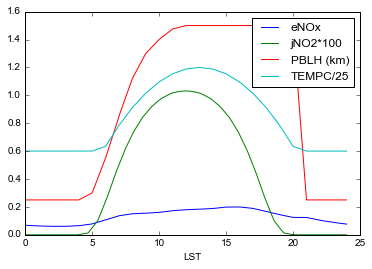

In [17]:
plt.figure()
plt.plot(data['t/3600'], data['emis_NO'], label = 'eNOx')
plt.plot(data['t/3600'], data['TUV_J(6,THETA)']*100, label = 'jNO2*100')
plt.plot(data['t/3600'], data['PBLH']/1000, label = 'PBLH (km)')
plt.xlabel('LST')
plt.plot(data['t/3600'], (data['TEMP'] - 273.15)/25., label = 'TEMPC/25')
plt.legend()

# Plot NOx Abundances

  - NOx in ppb
  - NO in ppb
  - NO2 in ppb

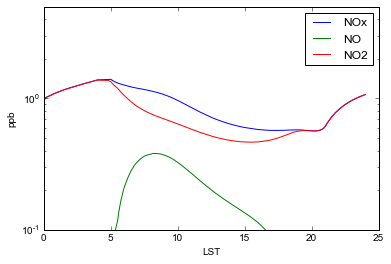

In [18]:
plt.figure()
plt.plot(data['t/3600'], data['NO'] + data['NO2'], label = 'NOx')
plt.plot(data['t/3600'], data['NO'], label = 'NO')
plt.plot(data['t/3600'], data['NO2'], label = 'NO2')
plt.ylabel('ppb')
plt.xlabel('LST')
plt.legend()
plt.ylim(0.1, 5)
plt.yscale('log')

# Plot O3 and HOx

  - Ozone in ppb
  - HO2 in ppb*1000 or pptv
  - HO in ppb/1e5 or ppqv

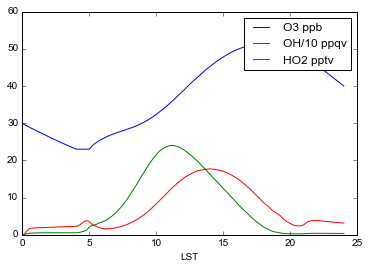

In [19]:
plt.figure()
plt.plot(data['t/3600'], data['O3'], label = 'O3 ppb')
plt.plot(data['t/3600'], data['OH']/10*1000**2, label = 'OH/10 ppqv')
plt.plot(data['t/3600'], data['HO2']*1000, label = 'HO2 pptv')
plt.xlabel('LST')
plt.legend()